In [575]:
import re

import pandas as pd
import ultraplot as uplt
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.stats.multitest import fdrcorrection
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error
import statsmodels.formula.api as sm

In [2]:
year = 2023

In [328]:
# Load all of the precipitation data and merge into one dataframe
prcp_df = pd.read_csv(f'./Data/TimeImpacts/prcp_grid_{year}_month_1.csv')
for i in range(2, 25):
    temp_df = pd.read_csv(f'./Data/TimeImpacts/prcp_grid_{year}_month_{i}.csv')
    prcp_df = prcp_df.merge(temp_df, how='inner', on='system:index', suffixes=(f'_{i-1}', f'_{i}'))

In [329]:
# Load all of the precipitation data and merge into one dataframe
tmax_df = pd.read_csv(f'./Data/TimeImpacts/tmax_grid_{year}_month_1.csv')
for i in range(2, 25):
    temp_df = pd.read_csv(f'./Data/TimeImpacts/tmax_grid_{year}_month_{i}.csv')
    tmax_df = tmax_df.merge(temp_df, how='inner', on='system:index', suffixes=(f'_{i-1}', f'_{i}'))

In [330]:
full_df = pd.read_csv(f'./Data/TimeImpacts/forest_grid_{year}.csv')
full_df = full_df.merge(prcp_df, how='inner', left_on='id', right_on='system:index')
full_df = full_df.merge(tmax_df, how='inner', on='system:index')
full_df = full_df.drop('id', axis=1)
full_df['defol_forest_2'] = full_df['defoliation_2']/full_df['forest']
full_df['defol_forest_mask_2'] = full_df['defoliation_2']/full_df['qa_mask_2']
full_df['defol_forest_3'] = full_df['defoliation_3']/full_df['forest']
full_df['defol_forest_mask_3'] = full_df['defoliation_3']/full_df['qa_mask_3']
full_df.to_csv(f'./Data/TimeImpacts/time_lags_months_{year}.csv')

# Lag Analysis

In [541]:
prcp_anom_cols = [f'prcp_anom_{i}' for i in range(1, 25)]
tmax_anom_cols = [f'tmax_anom_{i}' for i in range(1, 25)]
prcp_mean_cols = [f'prcp_mean_{i}' for i in range(1, 25)]
tmax_mean_cols = [f'tmax_mean_{i}' for i in range(1, 25)]

In [542]:
df_2021 = pd.read_csv('./Data/TimeImpacts/time_lags_months_2021.csv')

df_2023 = pd.read_csv('./Data/TimeImpacts/time_lags_months_2023.csv')

full_df = pd.concat([df_2021, df_2023], axis=0)

In [543]:
def make_lag_fig(df, prcp_cols, tmax_cols, metric, title):
    fig, axes = uplt.subplots(ncols=2, suptitle=title)
        
    corrs = []
    for prcp_anom_col in prcp_cols:
        corrs.append(df[prcp_anom_col].corr(df[metric]))
    corrs = np.array(corrs)
    
    i = np.argmax(np.abs(corrs))+1
    
    axes[0].axvline(i, color='red')
    axes[0].axhline(0, color='gray', linestyle='dashed')
    axes[0].plot(np.arange(1, corrs.shape[0]+1), corrs, color='black')
    axes[0].format(title='Precipitation Anomaly', xlabel='Weeks')
    
    corrs = []
    for tmax_anom_col in tmax_cols:
        corrs.append(df[tmax_anom_col].corr(df[metric]))
    corrs = np.array(corrs)
    
    i = np.argmax(np.abs(corrs))+1
    
    axes[1].axvline(i, color='red')
    axes[1].axhline(0, color='gray', linestyle='dashed')
    axes[1].plot(np.arange(1, corrs.shape[0]+1), corrs, color='black')
    axes[1].format(title='Max. Temperature Anomaly', xlabel='Weeks')

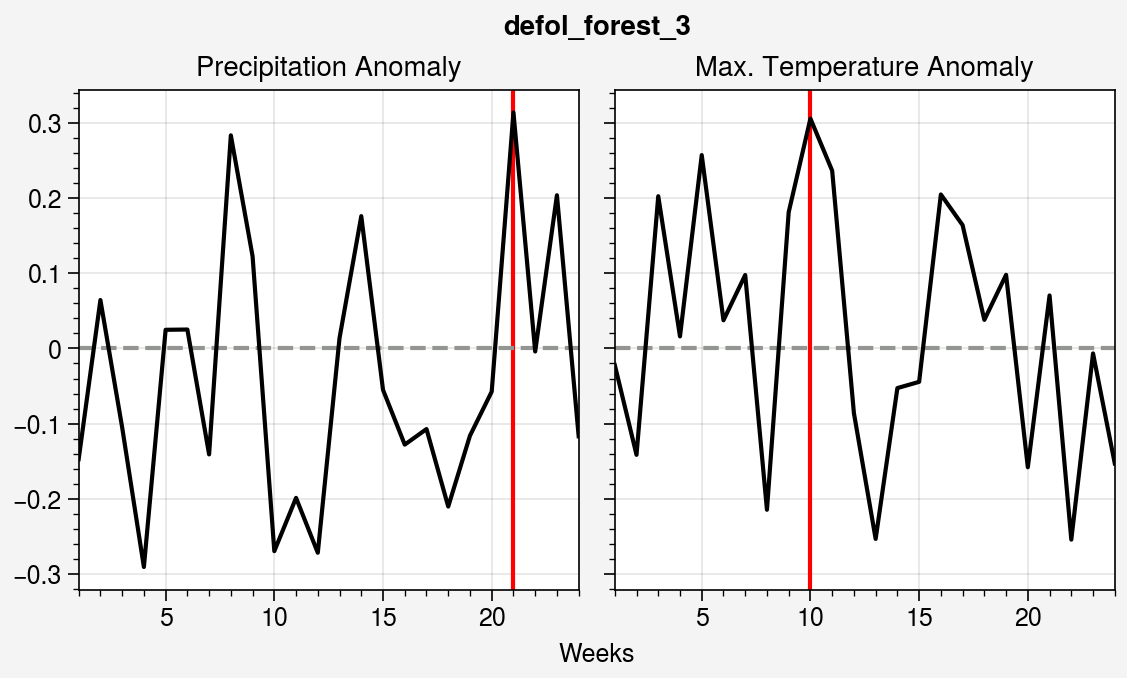

In [544]:
make_lag_fig(df_2023, prcp_anom_cols, tmax_anom_cols, 'defol_forest_3', 'defol_forest_3')

### Functions for creating aggregate columns

In [545]:
def calc_window(df, cols, prefix, i, j):
    # Aggregates specified columns. Return new dataframe and name of column appended.
    agg = df[cols[i]].copy()
    for k in range(i+1, j+1):
        agg += df[cols[k]]
    return agg.rename(f'{prefix}_{i+1}_{j+1}'), f'{prefix}_{i+1}_{j+1}'

In [546]:
def calc_all_window(df, cols, prefix, min_length, max_length):
    # Aggregates all windows up to a provide size. Returns new data frame and a list of names of all columns appended.
    new_cols = []
    new_cols_names = []
    for length in range(min_length, max_length+1):
        for i in range(0, 24-length):
            new_col, new_col_name = calc_window(df, cols, prefix, i, i+length)
            new_cols.append(new_col)
            new_cols_names.append(new_col_name)
    new_cols_df = pd.concat(new_cols, names=new_cols_names, axis=1)
    df = pd.concat([df, new_cols_df], axis=1)
    return df, new_cols_names

### Functions for creating correlation triples

In [547]:
def get_corr_triple(df, metric, cols, i, j):
    df['temp'] = 0
    for k in range(i, j+1):
        df['temp'] += df[cols[k]]
    return [i, j, df['temp'].corr(df[metric])]

In [548]:
def compute_corr_periods(df, metric, cols, max_length):
    triples = []
    for length in range(0, max_length+1):
        for i in range(0, 24-length):
            triples.append(get_corr_triple(df, metric, cols, i, i+length))
    return triples

In [549]:
def get_scaling(triples):
    vmax = max(triples, key=lambda x: abs(x[2]))
    return vmax[2]

### Functions for plotting

In [550]:
def plot_corr_triple(ax, triple, offset, width, cmap, vmax):
    color = cmap((triple[2]+vmax)/(2*vmax))
    #ax.fill_between(x,y-30,y+30)

    #ax.fill_between([-1*triple[0], -1*triple[1]-1], [offset]*2, [offset+width]*2, color=color, linewidth=1)
    ax.hlines(offset, -1*triple[0], -1*triple[1]-1, color=color, linewidth=0.75)#, alpha=abs(triple[2]/vmax))

In [551]:
def plot_triples(ax, triples, cmap, year):
    vmax = abs(get_scaling(triples))
    triples.sort(key=lambda x: x[1], reverse=True)
    for i, triple in enumerate(triples):
        plot_corr_triple(ax, triple, 0.3*i, 0.15, cmap, vmax)

    ax.format(xlocator=[-24, -12, 0], xticklabels=[f'{year-2}-06-01', f'{year-1}-06-01', f'{year}-06-01'], ylocator=[], xminorlocator=1, xtickminor=True, xlim=[-24.5, 0.5])
    ax.colorbar(cmap, locator=[0, 0.25, 0.5, 0.75, 1], ticklabels=[f'{-vmax:0.2f}', f'{-0.5*vmax:.2f}', f'{0}', f'{0.5*vmax:.2f}', f'{vmax:.2f}'], label='Correlation')

[1, 1, np.float64(0.17600603172832446)]
[2, 3, np.float64(0.13969139156793156)]


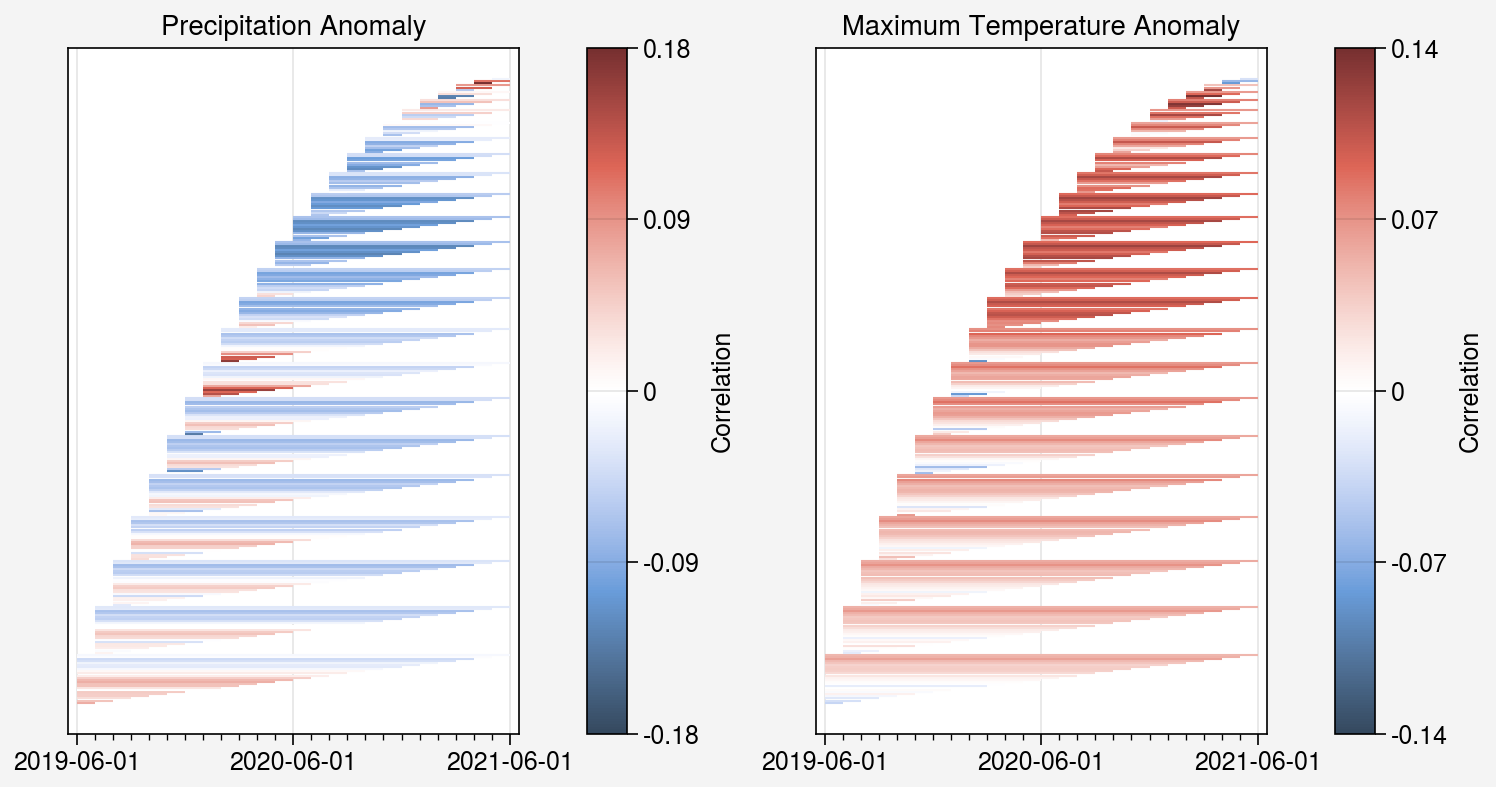

In [552]:
prcp_triples = compute_corr_periods(df_2021, 'defol_forest_3', prcp_anom_cols, 24)
tmax_triples = compute_corr_periods(df_2021, 'defol_forest_3', tmax_anom_cols, 24)
print(max(prcp_triples, key=lambda x: abs(x[2])))
print(max(tmax_triples, key=lambda x: abs(x[2])))
#triples = [triple for triple in triples if triple[2] > 0.05]

fig, axes = uplt.subplots(ncols=2, figsize=('190mm', '100mm'))

cmap = uplt.Colormap("NegPos")
plot_triples(axes[0], prcp_triples, cmap, 2021)
plot_triples(axes[1], tmax_triples, cmap, 2021)
axes[0].format(title='Precipitation Anomaly')
axes[1].format(title='Maximum Temperature Anomaly')
fig.savefig('./Figures/correlations_2021.svg')

[9, 11, np.float64(-0.3398218001901516)]
[9, 9, np.float64(0.3058659988531236)]


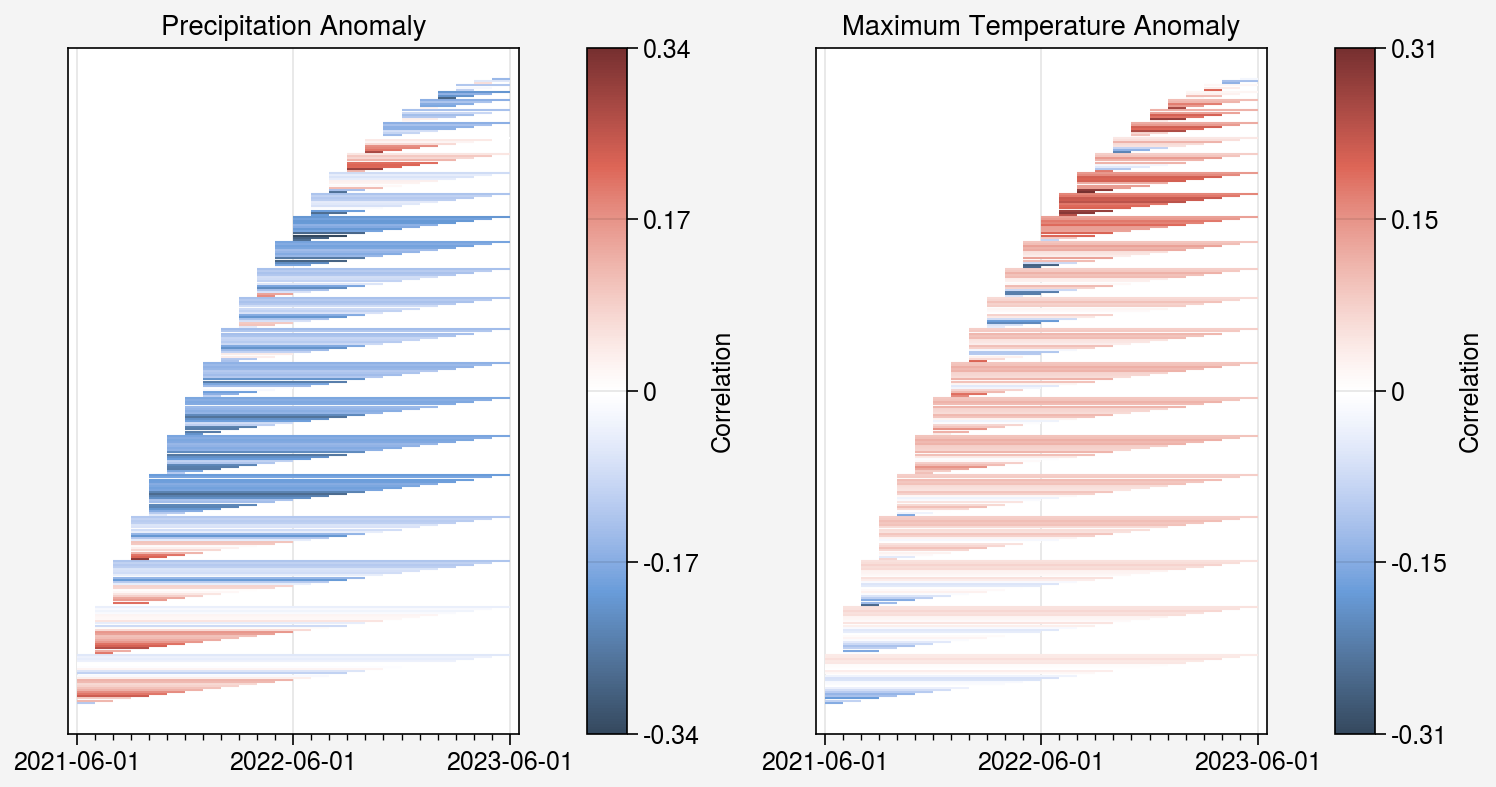

In [553]:
prcp_triples = compute_corr_periods(df_2023, 'defol_forest_3', prcp_anom_cols, 24)
tmax_triples = compute_corr_periods(df_2023, 'defol_forest_3', tmax_anom_cols, 24)
print(max(prcp_triples, key=lambda x: abs(x[2])))
print(max(tmax_triples, key=lambda x: abs(x[2])))
#triples = [triple for triple in triples if triple[2] > 0.05]

fig, axes = uplt.subplots(ncols=2, figsize=('190mm', '100mm'))
cmap = uplt.Colormap("NegPos")
plot_triples(axes[0], prcp_triples, cmap, 2023)
plot_triples(axes[1], tmax_triples, cmap, 2023)
axes[0].format(title='Precipitation Anomaly')
axes[1].format(title='Maximum Temperature Anomaly')
fig.savefig('./Figures/correlations_2023.svg')

How to include other drivers? Alternatively, how do we select the ideal interval for use? (e.g. is the answer simply to take the highest correlation period? In some cases that period is only a month long)
Alternatively, it could be reasonable to consider multiple periods, but I want to be careful of crossing statistical lines. 

C:\Users\camer\AppData\Local\Temp\ipykernel_1224\3448105334.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['temp'] = 0


[9, 11, np.float64(-0.2238301272642738)]
[9, 10, np.float64(0.19895866424967357)]


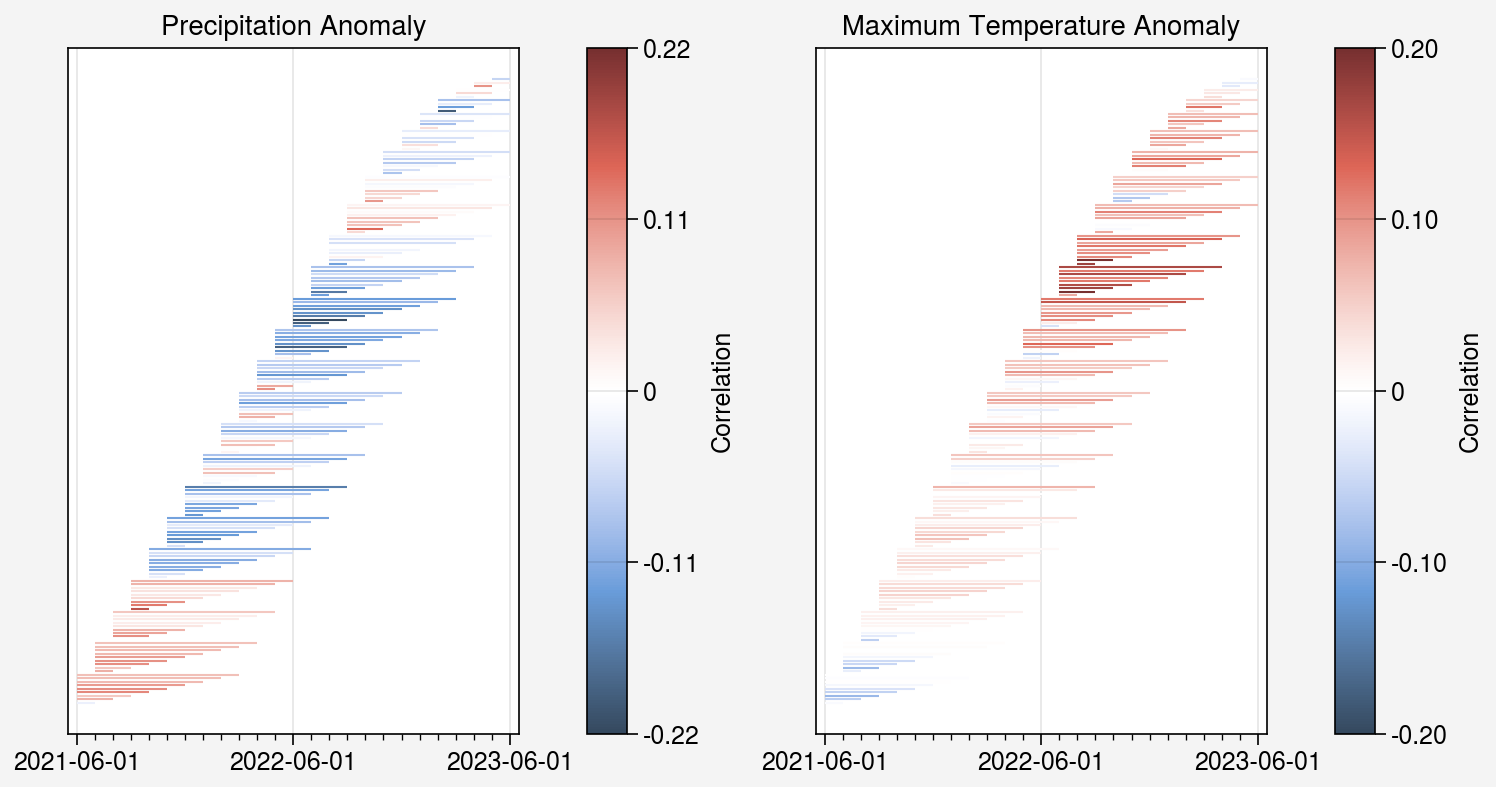

In [554]:
prcp_triples = compute_corr_periods(full_df, 'defol_forest_3', prcp_anom_cols, 8)
tmax_triples = compute_corr_periods(full_df, 'defol_forest_3', tmax_anom_cols, 8)
print(max(prcp_triples, key=lambda x: abs(x[2])))
print(max(tmax_triples, key=lambda x: abs(x[2])))
#triples = [triple for triple in triples if triple[2] > 0.05]

fig, axes = uplt.subplots(ncols=2, figsize=('190mm', '100mm'))
cmap = uplt.Colormap("NegPos")
plot_triples(axes[0], prcp_triples, cmap, 2023)
plot_triples(axes[1], tmax_triples, cmap, 2023)
axes[0].format(title='Precipitation Anomaly')
axes[1].format(title='Maximum Temperature Anomaly')
#fig.savefig('./Figures/correlations_2023.svg')

In [526]:
# Create dataframe with aggregated columns
prcp_df, prcp_agg_cols = calc_all_window(df_2023, prcp_anom_cols, 'prcp_anom', 0, 8)
tmax_df, tmax_agg_cols = calc_all_window(df_2023, tmax_anom_cols, 'tmax_anom', 0, 8)

In [527]:
# Standardize columns. Otherwise, there may be size biases.
for col in prcp_agg_cols:
    mean = prcp_df[col].mean()
    std = prcp_df[col].std()
    prcp_df[col] = (prcp_df[col]-mean) / std

for col in tmax_agg_cols:
    mean = tmax_df[col].mean()
    std = tmax_df[col].std()
    tmax_df[col] = (tmax_df[col]-mean) / std

In [528]:
mask = ~np.isnan(prcp_df['defol_forest_3'])
all_columns = prcp_agg_cols #+ tmax_agg_cols 
X = prcp_df.loc[mask, all_columns]
y = prcp_df.loc[mask, 'defol_forest_3']

# Use LASSO to reduce feature count
clf_prcp = Lasso(alpha=0.001, max_iter=10_000)
clf_prcp.fit(X, y)

# Determine non-zero factors
important_mask_prcp = ~np.isclose(clf_prcp.coef_, 0)
important_factors_prcp = [all_columns[i] for i in range(len(all_columns)) if important_mask_prcp[i]]
print(important_factors_prcp)
print(clf_prcp.coef_[important_mask_prcp])
prcp_max = max([abs(clf_prcp.coef_[i]) for i in range(len(all_columns)) if (important_mask_prcp[i] and all_columns[i][0:4] == 'prcp')])
values_prcp = clf_prcp.coef_[important_mask_prcp]

y_pred = clf_prcp.predict(X)
print(root_mean_squared_error(y, y_pred))

['prcp_anom_1_1', 'prcp_anom_3_3', 'prcp_anom_5_5', 'prcp_anom_7_7', 'prcp_anom_12_12', 'prcp_anom_22_22', 'prcp_anom_23_23', 'prcp_anom_1_2', 'prcp_anom_3_4', 'prcp_anom_11_12', 'prcp_anom_13_14', 'prcp_anom_16_17', 'prcp_anom_17_18', 'prcp_anom_17_19']
[ 2.02473521e-03 -1.59146874e-04  5.81860273e-03 -3.50627360e-04
 -4.59577107e-03 -2.53917821e-03  1.14080986e-02  8.64315319e-06
 -6.27141837e-03 -1.20444563e-02  8.50022292e-03 -1.44945551e-03
 -8.74060891e-03 -1.22140128e-04]
0.044018699204106566


In [529]:
mask = ~np.isnan(tmax_df['defol_forest_3'])
all_columns = tmax_agg_cols #+ tmax_agg_cols 
X = tmax_df.loc[mask, all_columns]
y = tmax_df.loc[mask, 'defol_forest_3']

# Use LASSO to reduce feature count
clf_tmax = Lasso(alpha=0.001, max_iter=10_000)
clf_tmax.fit(X, y)

# Determine non-zero factors
important_mask_tmax = ~np.isclose(clf_tmax.coef_, 0)
important_factors_tmax = [all_columns[i] for i in range(len(all_columns)) if important_mask_tmax[i]]
print(important_factors_tmax)
print(clf_tmax.coef_[important_mask_tmax])
tmax_max = max([abs(clf_tmax.coef_[i]) for i in range(len(all_columns)) if (important_mask_tmax[i] and all_columns[i][0:4] == 'tmax')])
values_tmax = clf_tmax.coef_[important_mask_tmax]

y_pred = clf_tmax.predict(X)
print(root_mean_squared_error(y, y_pred))

['tmax_anom_2_2', 'tmax_anom_3_3', 'tmax_anom_6_6', 'tmax_anom_10_10', 'tmax_anom_18_18', 'tmax_anom_21_21', 'tmax_anom_23_23', 'tmax_anom_24_24', 'tmax_anom_5_6', 'tmax_anom_10_11', 'tmax_anom_12_13', 'tmax_anom_18_19', 'tmax_anom_22_23', 'tmax_anom_13_15', 'tmax_anom_3_6', 'tmax_anom_3_11']
[-0.00121352  0.0009681   0.00056566  0.00272099  0.01144199  0.00079435
 -0.00854342  0.00528889  0.00103451  0.00256982 -0.00807856  0.00680678
 -0.004413   -0.01473272  0.00069922  0.00657498]
0.0450695699239971


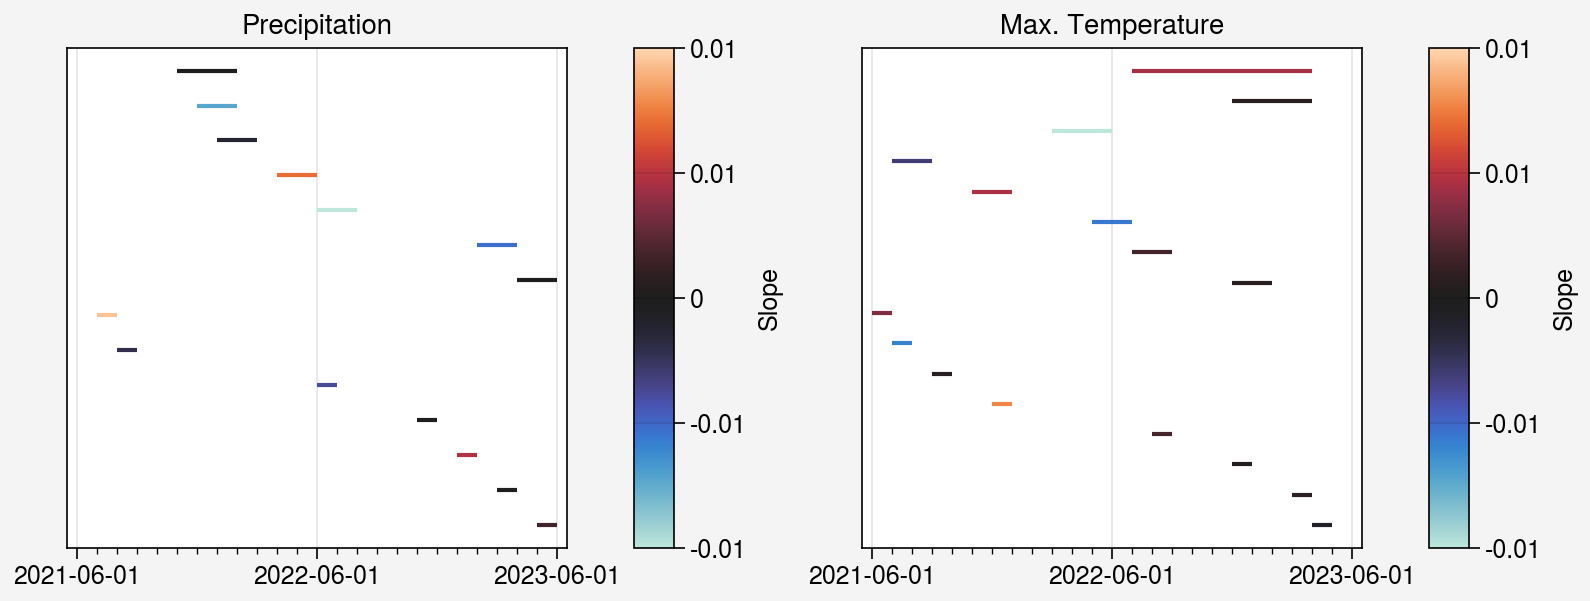

In [530]:
fig, axes = uplt.subplots(ncols=2,sharey=False)
prcp_offset = 0
tmax_offset = 0
cmap = uplt.Colormap("IceFire")
vmax = np.max(np.abs(clf_prcp.coef_))
for i, factor in enumerate(important_factors_prcp):
    end = int(factor.split('_')[2])
    start = int(factor.split('_')[3])
    color = cmap((values_prcp[i]+vmax)/(2*vmax))
    axes[0].hlines(prcp_offset, -1*end+1, -1*start, color=color)
    prcp_offset += 1
axes[0].colorbar(cmap, locator=[0, 0.25, 0.5, 0.75, 1], ticklabels=[f'{-vmax:0.2f}', f'{-0.5*vmax:.2f}', f'{0}', f'{0.5*vmax:.2f}', f'{vmax:.2f}'], label='Slope')

prcp_offset = 0
tmax_offset = 0
cmap = uplt.Colormap("IceFire")
vmax = np.max(np.abs(clf_tmax.coef_))
for i, factor in enumerate(important_factors_tmax):
    end = int(factor.split('_')[2])
    start = int(factor.split('_')[3])
    color = cmap((values_tmax[i]+vmax)/(2*vmax))
    axes[1].hlines(tmax_offset, -1*end+1, -1*start, color=color)
    tmax_offset += 1
axes[0].format(title='Precipitation')
axes[1].format(title='Max. Temperature')

axes[1].colorbar(cmap, locator=[0, 0.25, 0.5, 0.75, 1], ticklabels=[f'{-vmax:0.2f}', f'{-0.5*vmax:.2f}', f'{0}', f'{0.5*vmax:.2f}', f'{vmax:.2f}'], label='Slope')

axes.format(xlocator=[-24, -12, 0], xticklabels=[f'{year-2}-06-01', f'{year-1}-06-01', f'{year}-06-01'], ylocator=[], xminorlocator=1, xtickminor=True, xlim=[-24.5, 0.5])

### Make Correlation grid

#### Anomalies

In [725]:
max_length = 8
prcp_grid = np.zeros((max_length, 24))

for length in range(0, max_length):
    for i in range(0, 24-length):
        triple = get_corr_triple(full_df, 'defol_forest_3', prcp_anom_cols, i, i+length)
        prcp_grid[length, 24-i-length-1] = triple[2]

In [726]:
tmax_grid = np.zeros((max_length, 24))

for length in range(0, max_length):
    for i in range(0, 24-length):
        triple = get_corr_triple(full_df, 'defol_forest_3', tmax_anom_cols, i, i+length)
        tmax_grid[length, 24-i-length-1] = triple[2]

C:\Users\camer\AppData\Local\Temp\ipykernel_1224\1554353114.py:27: UltraPlotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axes.plot(x, y, color='gray', linewidth=1)
C:\Users\camer\AppData\Local\Temp\ipykernel_1224\1554353114.py:44: UltraPlotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axes.axvline(11.5, color='black')


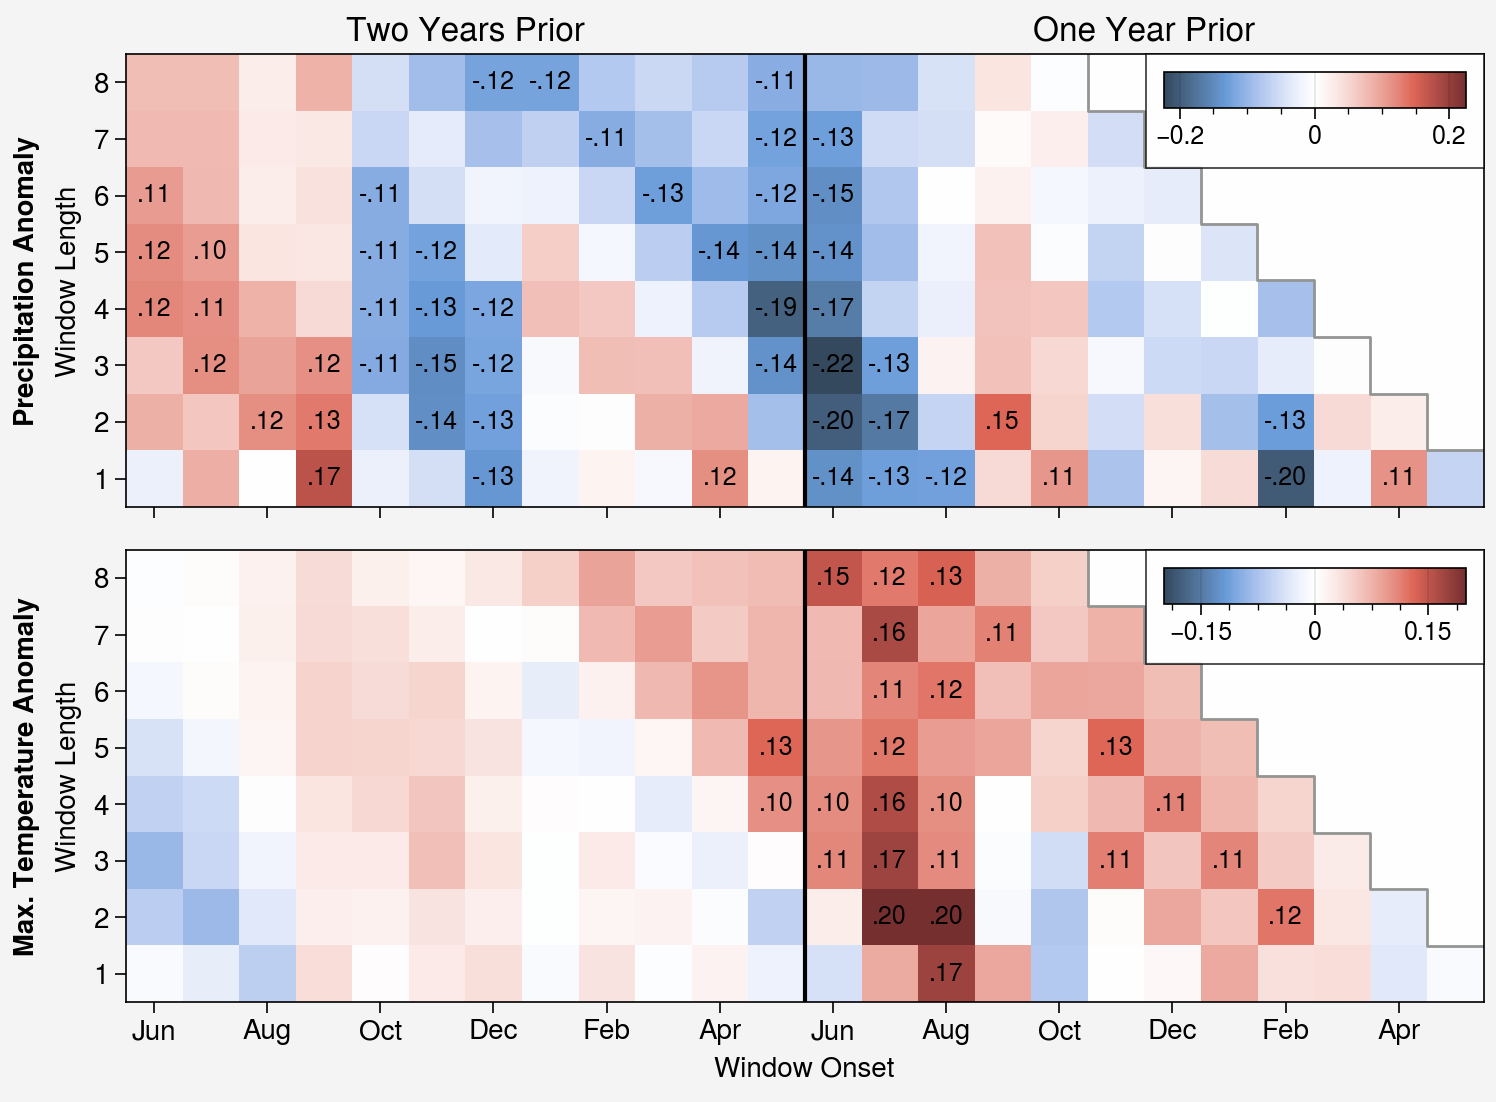

In [727]:
fig, axes = uplt.subplots(nrows=2, figsize=('190mm', '140mm'), sharey=False, fontsize=10)

# Plot correlation plots and add corresponding colorbars
vmax = np.max(np.abs(prcp_grid))
m = axes[0].imshow(prcp_grid, cmap='NegPos', vmin=-vmax, vmax=vmax)
axes[0].colorbar(m, loc='ur', locator=[-0.2, 0, 0.2], length=11.75, width=1.4)

vmax = np.max(np.abs(tmax_grid))
m = axes[1].imshow(tmax_grid, cmap='NegPos', vmin=-vmax, vmax=vmax)
axes[1].colorbar(m, loc='ur', locator=[-0.15, 0, 0.15], length=11.75, width=1.4)

axes.format(ylim=[-0.5,7.5], grid=False,
            xlocator=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
            #xticklabels=['24', '22', '20', '18', '16', '14', '12', '10', '8', '6', '4', '2'],
            xticklabels=['Jun', 'Aug', 'Oct', 'Dec', 'Feb', 'Apr']*2,
            xlabel='Window Onset',
            ylocator=list(range(8)),
            yticklabels=['1', '2', '3', '4', '5', '6', '7', '8'],
            ylabel='Window Length',
            leftlabels=['Precipitation Anomaly', 'Max. Temperature Anomaly'])

# Add right hand borders to separate 'nonsensical' regions
x = [16.5, 16.5, 17.5, 17.5, 18.5, 18.5, 19.5, 19.5, 
     20.5, 20.5, 21.5, 21.5, 22.5, 22.5, 23.5]
y = [7.5, 6.5, 6.5, 5.5, 5.5, 4.5, 4.5,
     3.5, 3.5, 2.5, 2.5, 1.5, 1.5, 0.5, 0.5]
axes.plot(x, y, color='gray', linewidth=1)

# Add titles
axes[0].text(0.25, 1.05, 'Two Years Prior', 
             transform=axes[0].transAxes,
             fontsize=12,
             va='center',
             ha='center')

axes[0].text(0.75, 1.05, 'One Year Prior', 
             transform=axes[0].transAxes,
             fontsize=12,
             va='center',
             ha='center')


# Add Year Transition line to each plot
axes.axvline(11.5, color='black')

# Loop over data dimensions and create text annotations.
for i in range(max_length):
    for j in range(24):
        if np.abs(prcp_grid[i,j]) >= 0.1:
            text = axes[0].text(j, i, re.sub('0(?=[.])', '', f'{prcp_grid[i, j]:.2f}'),
                                ha="center", va="center", color="black")

for i in range(max_length):
    for j in range(24):
        if np.abs(tmax_grid[i,j]) >= 0.1:
            text = axes[1].text(j, i, re.sub('0(?=[.])', '', f'{tmax_grid[i, j]:.2f}'),
                                ha="center", va="center", color="black")

fig.savefig('./Figures/Enviro/correlation_anomalies.png')

### Means

In [646]:
max_length = 8
prcp_grid = np.zeros((max_length, 24))

for length in range(0, max_length):
    for i in range(0, 24-length):
        triple = get_corr_triple(full_df, 'defol_forest_3', prcp_mean_cols, i, i+length)
        prcp_grid[length, 24-i-length-1] = triple[2]

In [647]:
tmax_grid = np.zeros((max_length, 24))

for length in range(0, max_length):
    for i in range(0, 24-length):
        triple = get_corr_triple(full_df, 'defol_forest_3', tmax_mean_cols, i, i+length)
        tmax_grid[length, 24-i-length-1] = triple[2]

C:\Users\camer\AppData\Local\Temp\ipykernel_1224\231181581.py:26: UltraPlotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axes.plot(x, y, color='gray', linewidth=1)
C:\Users\camer\AppData\Local\Temp\ipykernel_1224\231181581.py:43: UltraPlotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axes.axvline(11.5, color='black')


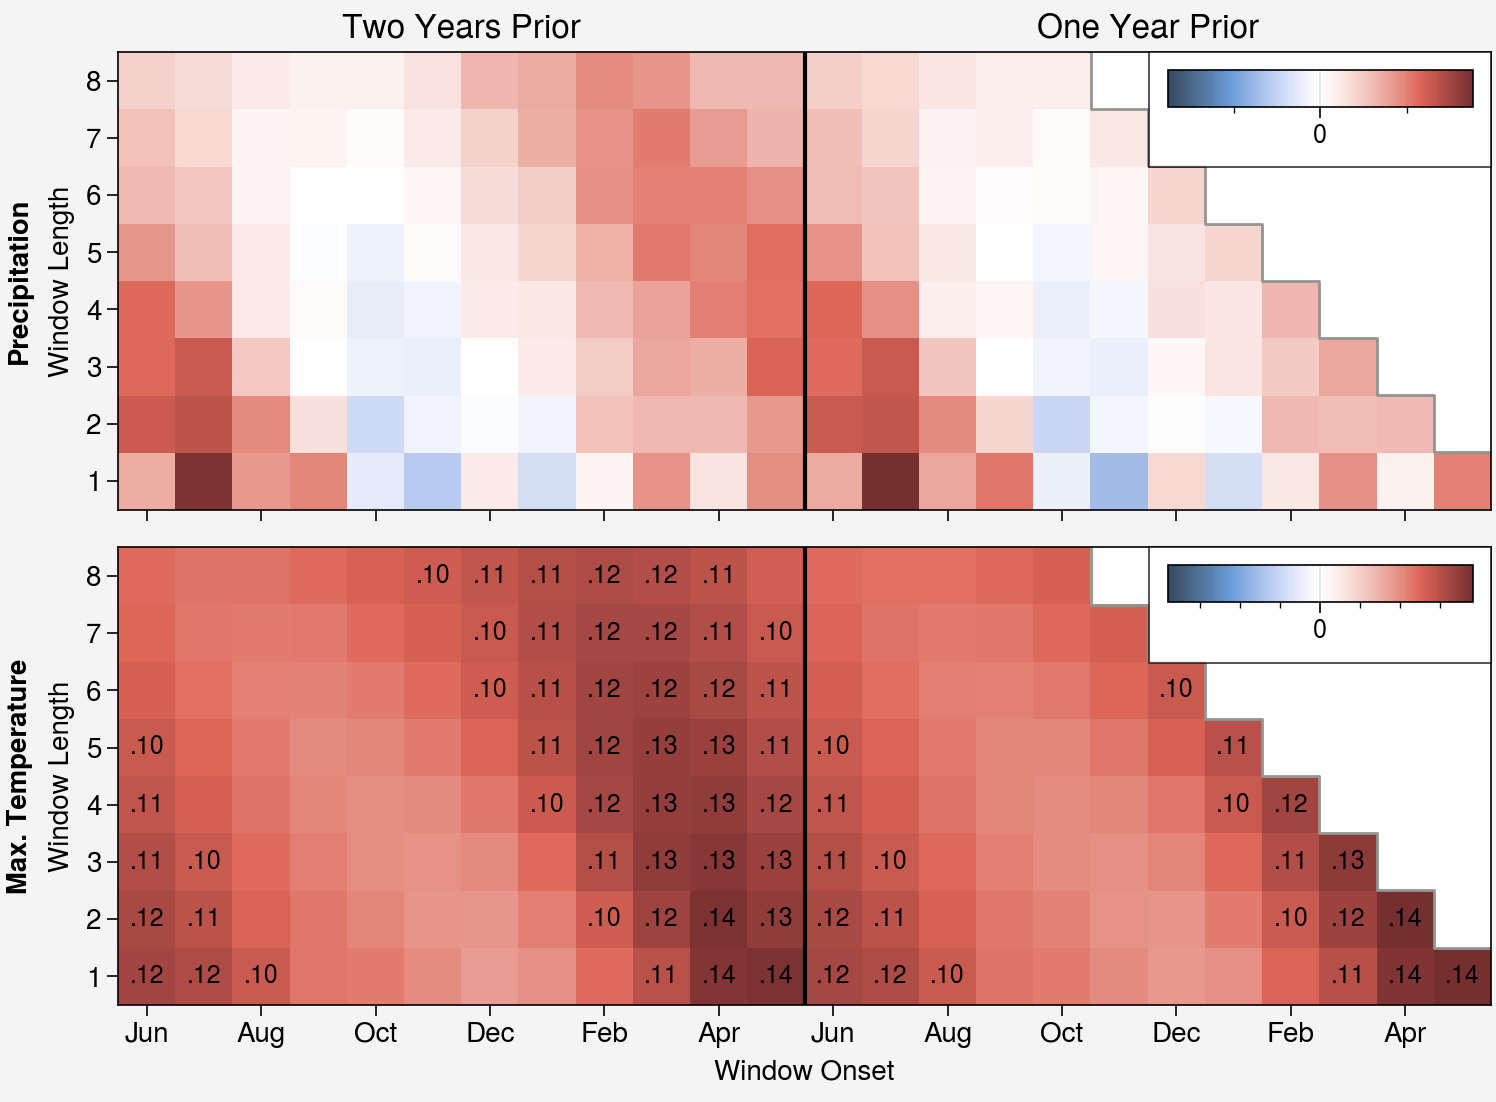

In [648]:
fig, axes = uplt.subplots(nrows=2, figsize=('190mm', '140mm'), sharey=False, fontsize=10)

# Plot correlation plots and add corresponding colorbars
vmax = np.max(np.abs(prcp_grid))
m = axes[0].imshow(prcp_grid, cmap='NegPos', vmin=-vmax, vmax=vmax)
axes[0].colorbar(m, loc='ur', locator=[-0.2, 0, 0.2], length=11.75, width=1.4)

vmax = np.max(np.abs(tmax_grid))
m = axes[1].imshow(tmax_grid, cmap='NegPos', vmin=-vmax, vmax=vmax)
axes[1].colorbar(m, loc='ur', locator=[-0.15, 0, 0.15], length=11.75, width=1.4)

axes.format(ylim=[-0.5,7.5], grid=False,
            xlocator=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
            xticklabels=['Jun', 'Aug', 'Oct', 'Dec', 'Feb', 'Apr']*2,
            xlabel='Window Onset',
            ylocator=list(range(8)),
            yticklabels=['1', '2', '3', '4', '5', '6', '7', '8'],
            ylabel='Window Length',
            leftlabels=['Precipitation', 'Max. Temperature'])

# Add right hand borders to separate 'nonsensical' regions
x = [16.5, 16.5, 17.5, 17.5, 18.5, 18.5, 19.5, 19.5, 
     20.5, 20.5, 21.5, 21.5, 22.5, 22.5, 23.5]
y = [7.5, 6.5, 6.5, 5.5, 5.5, 4.5, 4.5,
     3.5, 3.5, 2.5, 2.5, 1.5, 1.5, 0.5, 0.5]
axes.plot(x, y, color='gray', linewidth=1)

# Add titles
axes[0].text(0.25, 1.05, 'Two Years Prior', 
             transform=axes[0].transAxes,
             fontsize=12,
             va='center',
             ha='center')

axes[0].text(0.75, 1.05, 'One Year Prior', 
             transform=axes[0].transAxes,
             fontsize=12,
             va='center',
             ha='center')


# Add Year Transition line to each plot
axes.axvline(11.5, color='black')

# Loop over data dimensions and create text annotations.
for i in range(max_length):
    for j in range(24):
        if np.abs(prcp_grid[i,j]) >= 0.1:
            text = axes[0].text(j, i, re.sub('0(?=[.])', '', f'{prcp_grid[i, j]:.2f}'),
                                ha="center", va="center", color="black")

for i in range(max_length):
    for j in range(24):
        if np.abs(tmax_grid[i,j]) >= 0.1:
            text = axes[1].text(j, i, re.sub('0(?=[.])', '', f'{tmax_grid[i, j]:.2f}'),
                                ha="center", va="center", color="black")

# Comprehensive OLS + Partial Regressions

## Generate Features for analysis

In [678]:
# Select strongest correlation periods for both precipitation anomaly and max temp anomaly.
full_df['prcp_anom_10_12'] = calc_window(full_df, prcp_anom_cols, 'prcp_anom', 9, 11)[0]
full_df['tmax_anom_10_11'] = calc_window(full_df, tmax_anom_cols, 'tmax_anom', 9, 10)[0]
# Fraction deciduous as a rough approximation for palatability.
full_df['frac_deciduous'] = full_df['deciduous'] / full_df['forest']
# Calculate mean prcp/temp for several periods to decide which is most important.
full_df['prcp_mean_spring'] = calc_window(full_df, prcp_mean_cols, 'prcp_mean', 12, 14)[0]
full_df['prcp_mean_growing_season'] = calc_window(full_df, prcp_mean_cols, 'prcp_mean', 8, 12)[0]
full_df['prcp_mean_annual'] = calc_window(full_df, prcp_mean_cols, 'prcp_mean', 5, 16)[0]
full_df['tmax_mean_spring'] = calc_window(full_df, tmax_mean_cols, 'tmax_mean', 12, 14)[0]
full_df['tmax_mean_growing_season'] = calc_window(full_df, tmax_mean_cols, 'tmax_mean', 8, 12)[0]
full_df['tmax_mean_annual'] = calc_window(full_df, tmax_mean_cols, 'tmax_mean', 5, 16)[0]

C:\Users\camer\AppData\Local\Temp\ipykernel_1224\1886100403.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df['tmax_mean_spring'] = calc_window(full_df, tmax_mean_cols, 'tmax_mean', 12, 14)[0]
C:\Users\camer\AppData\Local\Temp\ipykernel_1224\1886100403.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df['tmax_mean_growing_season'] = calc_window(full_df, tmax_mean_cols, 'tmax_mean', 8, 12)[0]
C:\Users\camer\AppData\Local\Temp\ipykernel_1224\1886100403.py:12: PerformanceWarning: DataFrame is highly fragmented. 

In [687]:
def partial_regression(ax, data, x_residual, x_initial, y, xlabel, mls_pvalue, ms=10, ls='dashed'):
    # Compute x residuals
    formula = x_residual + ' ~ ' + ' + '.join(x_initial)
    x_reg = sm.ols(formula=formula, data=data).fit()

    predicted = x_reg.params['Intercept']
    for x in x_initial:
        predicted += x_reg.params[x]*data[x]
    data['x_residuals'] = data[x_residual] - predicted
    
    # Compute y residuals
    formula = y + ' ~ ' + ' + '.join(x_initial)
    y_reg = sm.ols(formula=formula, data=data).fit()
    
    predicted = y_reg.params['Intercept']
    for x in x_initial:
        predicted += y_reg.params[x]*data[x]
    data['y_residuals'] = data[y] - predicted
    
    # Compute partial regression
    res_reg = sm.ols('y_residuals ~ x_residuals', data=data).fit()

    # Plot residuals
    ax.scatter(data['x_residuals'], data['y_residuals'], color='gray', markersize=ms)

    x = np.array(ax.get_xlim())
    y_pred = res_reg.params['Intercept'] + res_reg.params['x_residuals']*x

    print(res_reg.params['x_residuals'])

    # Plot partial regression
    ax.plot(x, y_pred, color='black', linestyle=ls)
    ax.format(xlabel=xlabel, ylabel='Residuals',
              upperrighttitle=f'slope={res_reg.params['x_residuals']:.4f}\np={mls_pvalue:.4f}')

# With mean spring

In [737]:
factors = ['prcp_anom_10_12',
           'tmax_anom_10_11',
           'frac_deciduous',
           'prcp_mean_spring',
           'tmax_mean_spring']
factor_names = ['Precipitation Anomaly',
                'Max. Temperature Anomaly',
                'Frac. Deciduous Forest',
                'Spring Mean Precipitation',
                'Spring Mean Max. Tempearture']
mod_spring = sm.ols(formula='defol_forest_3 ~ ' + ' + '.join(factors), data=full_df)

res_spring = mod_spring.fit()

print(res_spring.summary())

                            OLS Regression Results                            
Dep. Variable:         defol_forest_3   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     35.84
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           1.11e-35
Time:                        13:59:52   Log-Likelihood:                 4480.1
No. Observations:                2824   AIC:                            -8948.
Df Residuals:                    2818   BIC:                            -8913.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0034      0.012  

-0.0001335849594933707
0.0001763305761025082
-0.0037503051210212
1.1092420985733942e-05
9.915603901451174e-06


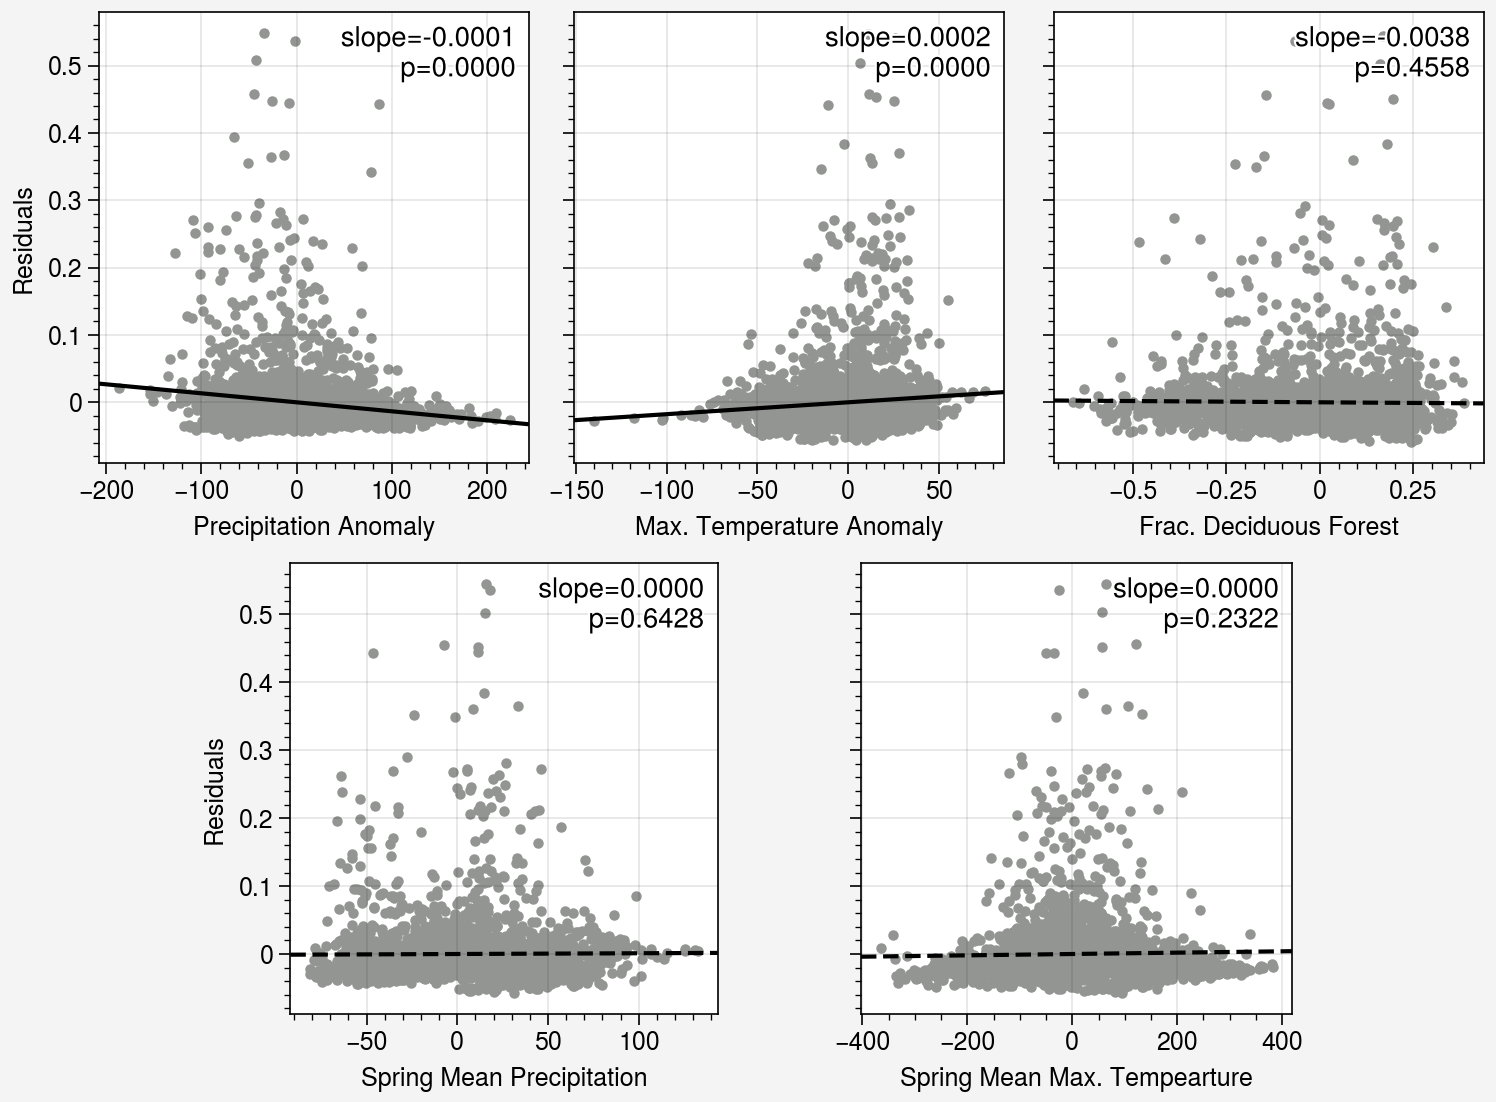

In [738]:
layout = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3], 
          [0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0]]

fig, axes = uplt.subplots(layout, sharex=False, figsize=('190mm', '140mm'))

for i, factor in enumerate(factors):
    if res_spring.pvalues.iloc[i+1] < 0.01:
        ls = 'solid'
    else:
        ls = 'dashed'
    partial_regression(axes[i], 
                       full_df, 
                       factor, 
                       [f for f in factors if f != factor], 
                       'defol_forest_3', 
                       factor_names[i], 
                       res_spring.pvalues.iloc[i+1],
                       ls=ls)

fig.savefig('./Figures/Enviro/spring_partial_regression.png')

## With mean growing season

In [720]:
factors = ['prcp_anom_10_12',
           'tmax_anom_10_11',
           'frac_deciduous',
           'prcp_mean_growing_season',
           'tmax_mean_growing_season']
factor_names = ['Precipitation Anomaly',
                'Max. Temperature Anomaly',
                'Frac. Deciduous Forest',
                'Growing Season Mean Precipitation',
                'Growing Season Mean Max. Tempearture']
mod_growing_season = sm.ols(formula='defol_forest_3 ~ ' + ' + '.join(factors), data=full_df)

res_growing_season = mod_growing_season.fit()

print(res_growing_season.summary())

                            OLS Regression Results                            
Dep. Variable:         defol_forest_3   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     40.58
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           2.00e-40
Time:                        12:42:25   Log-Likelihood:                 4491.2
No. Observations:                2824   AIC:                            -8970.
Df Residuals:                    2818   BIC:                            -8935.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

-0.00013592853222548675
0.00019039649485632078
-0.0029940410871376806
9.58619167307869e-06
7.506977779144044e-07


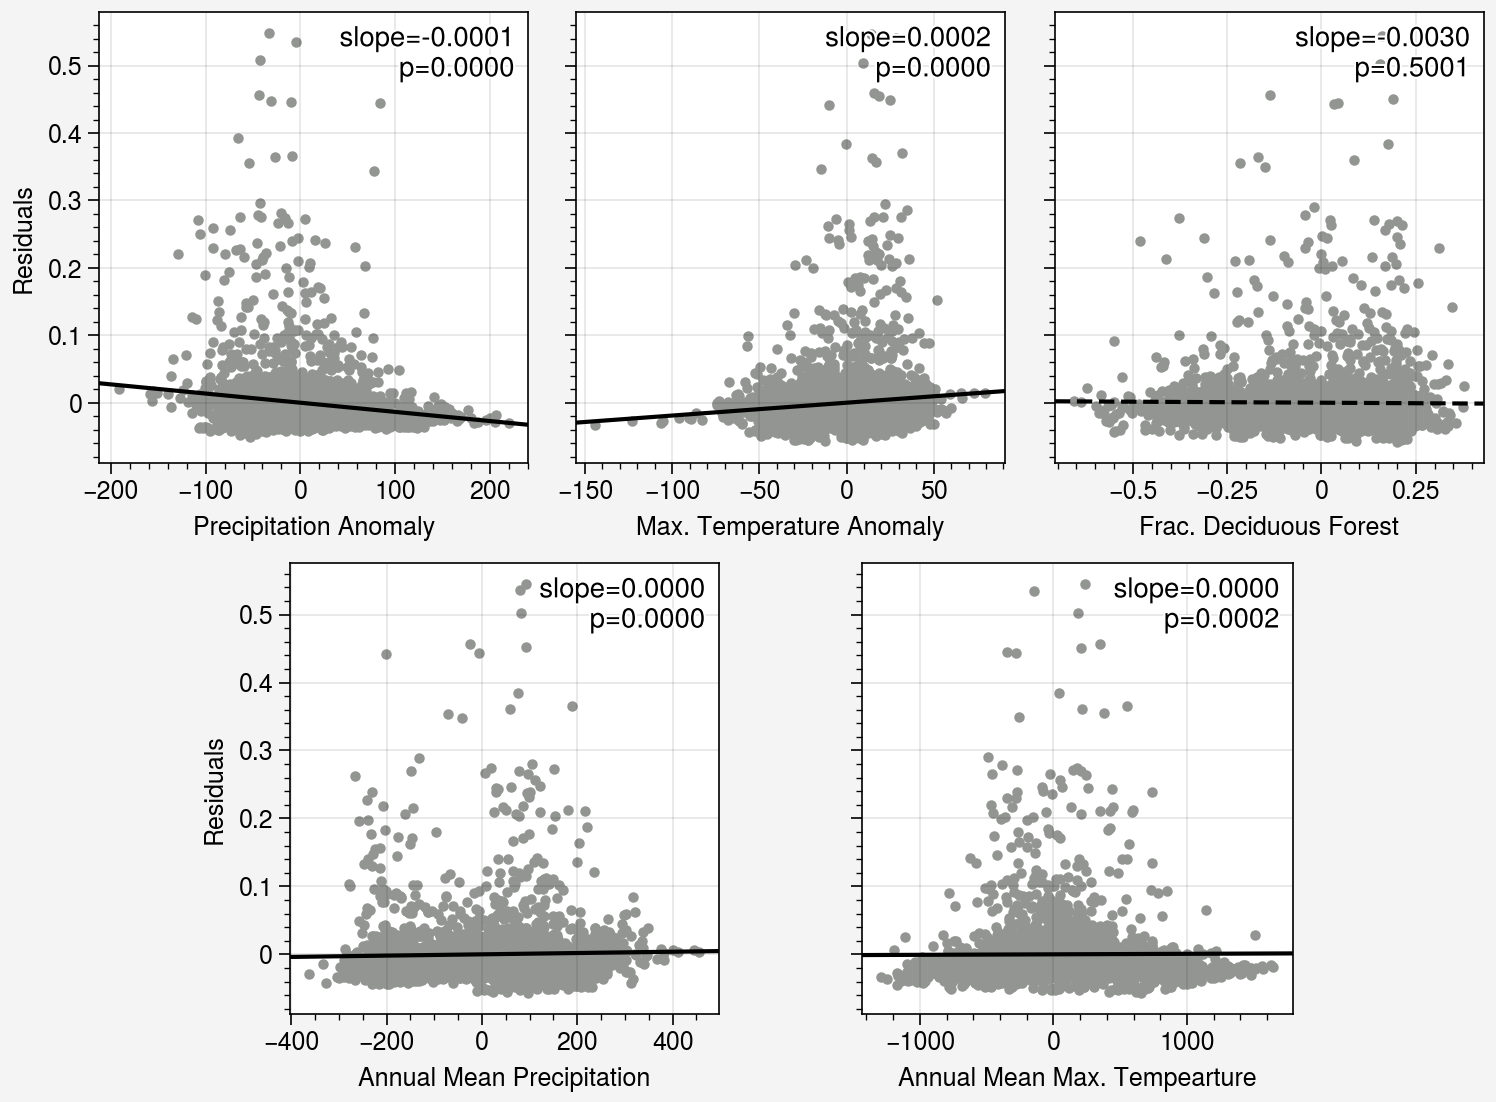

In [735]:
layout = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3], 
          [0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0]]

fig, axes = uplt.subplots(layout, sharex=False, figsize=('190mm', '140mm'))

for i, factor in enumerate(factors):
    if res_growing_season.pvalues.iloc[i+1] < 0.01:
        ls = 'solid'
    else:
        ls = 'dashed'
    partial_regression(axes[i], 
                       full_df, 
                       factor, 
                       [f for f in factors if f != factor], 
                       'defol_forest_3', 
                       factor_names[i], 
                       res_growing_season.pvalues.iloc[i+1],
                       ls=ls)

fig.savefig('./Figures/Enviro/growing_season_partial_regression.png')

## With mean annual conditions

In [722]:
factors = ['prcp_anom_10_12',
           'tmax_anom_10_11',
           'frac_deciduous',
           'prcp_mean_annual',
           'tmax_mean_annual']
factor_names = ['Precipitation Anomaly',
                'Max. Temperature Anomaly',
                'Frac. Deciduous Forest',
                'Annual Mean Precipitation',
                'Annual Mean Max. Tempearture']
mod_annual = sm.ols(formula='defol_forest_3 ~ ' + ' + '.join(factors), data=full_df)

res_annual = mod_annual.fit()

print(res_annual.summary())

                            OLS Regression Results                            
Dep. Variable:         defol_forest_3   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     35.98
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           8.07e-36
Time:                        12:44:44   Log-Likelihood:                 4480.4
No. Observations:                2824   AIC:                            -8949.
Df Residuals:                    2818   BIC:                            -8913.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0055      0.014  

-0.00013592853222548675
0.00019039649485632078
-0.0029940410871376806
9.58619167307869e-06
7.506977779144044e-07


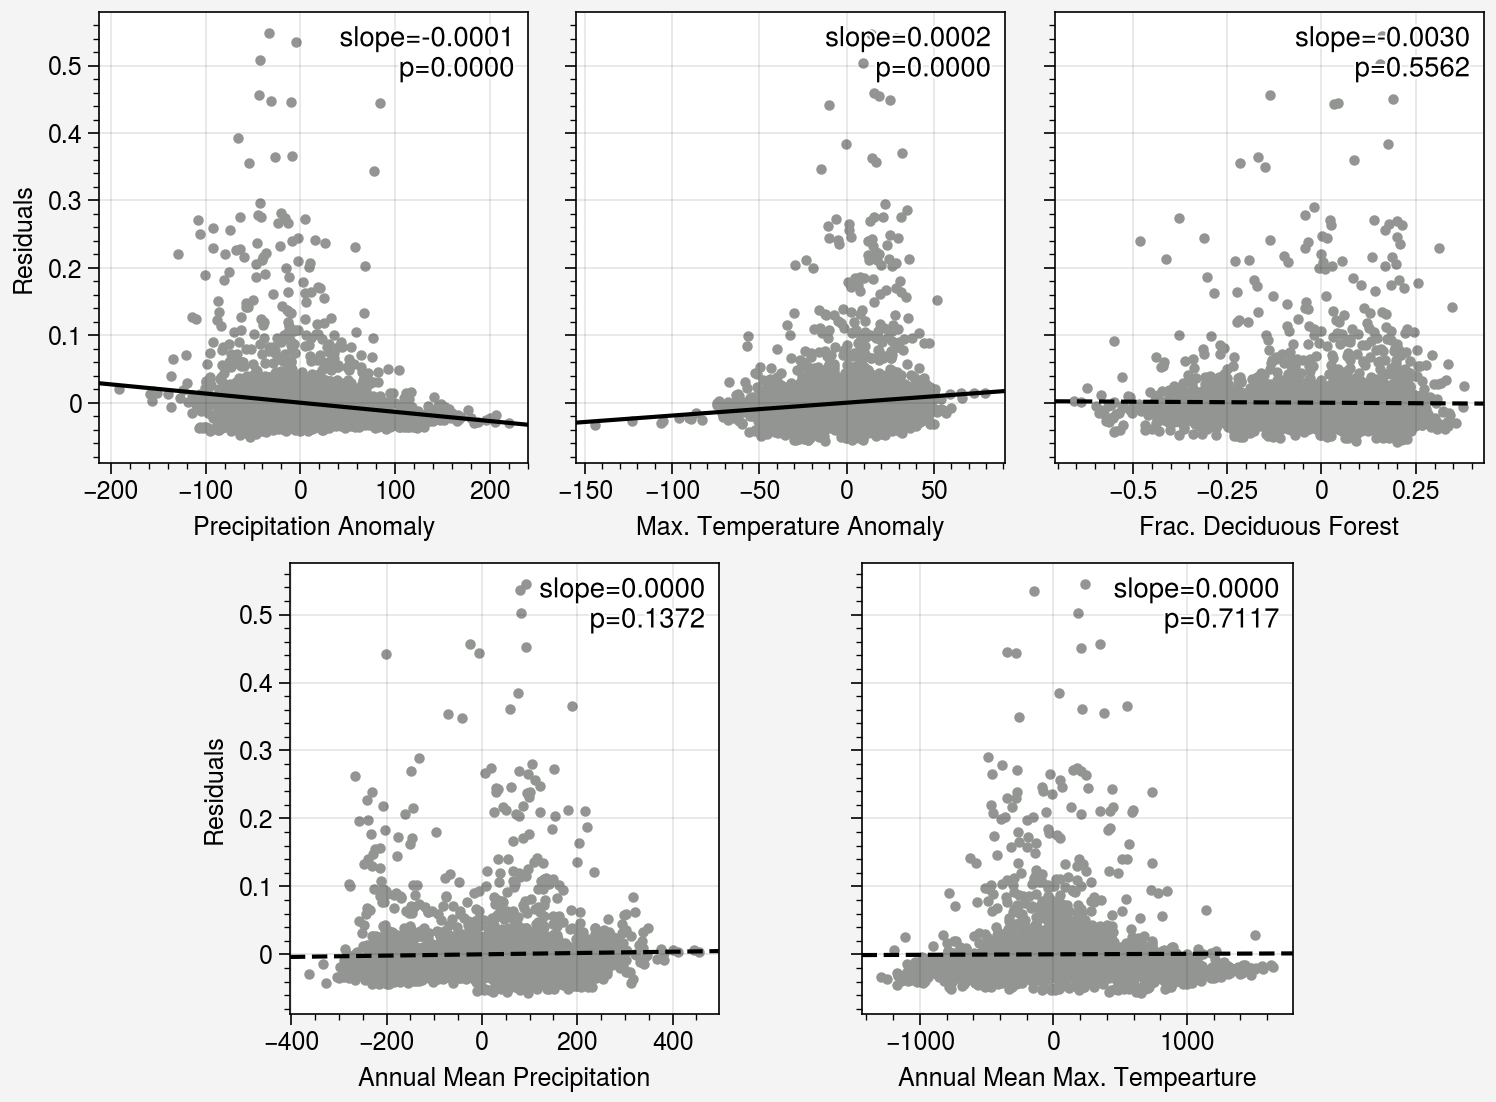

In [736]:
layout = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3], 
          [0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0]]
fig, axes = uplt.subplots(layout, sharex=False, figsize=('190mm', '140mm'))

for i, factor in enumerate(factors):
    if res_annual.pvalues.iloc[i+1] < 0.01:
        ls = 'solid'
    else:
        ls = 'dashed'
    partial_regression(axes[i], 
                       full_df, 
                       factor, 
                       [f for f in factors if f != factor], 
                       'defol_forest_3', 
                       factor_names[i], 
                       res_annual.pvalues.iloc[i+1],
                       ls=ls)
fig.savefig('./Figures/Enviro/annual_partial_regression.png')

In [732]:
fdrcorrection(list(res_spring.pvalues.iloc[1:])
              + list(res_growing_season.pvalues.iloc[1:])
              + list(res_annual.pvalues.iloc[1:]), 
              alpha=0.1, method='indep', is_sorted=False)

(array([ True,  True, False, False, False,  True,  True, False,  True,
         True,  True,  True, False, False, False]),
 array([7.12578374e-12, 1.12721109e-05, 6.21587982e-01, 6.88683625e-01,
        3.48264201e-01, 3.16160897e-11, 9.47675740e-05, 6.25146820e-01,
        1.12721109e-05, 3.46034217e-04, 7.12578374e-12, 1.56509342e-06,
        6.41794399e-01, 2.28749672e-01, 7.11692672e-01]))